In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pylab as pylab
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from backtrader.indicators import EMA
import backtrader.analyzers as btanalyzers
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from collections import deque
from pandas.tseries.offsets import BDay
from IPython.display import display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from collections import deque
import os.path
from keras.models import model_from_json
import pickle
from itertools import product
from functools import partial
import tensorflow as tf
import itertools
pylab.rcParams['figure.figsize'] = 40, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "40"

Using TensorFlow backend.


In [2]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [76]:
def run_backtest(aStrategy,  startdate ='2017-01-01', fromdate = '2010-01-01', todate = '2018-01-01', duration = 30, label="s", plot = False):
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    startdate = pd.to_datetime(startdate)
    enddate = startdate + BDay(duration)
    
    fromdate=startdate - BDay(100)
    todate=enddate + BDay(50)
    
    # Add a strategy
    cerebro.addstrategy(aStrategy, start_date = startdate, duration = duration, end_date=enddate)

    datapath = os.path.join('sp.csv')
    
    
    
    # Create a Data Feed
    
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=pd.to_datetime(fromdate),
        # Do not pass values before this date
        todate=pd.to_datetime(todate),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='%s.csv'%label,csv=True)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    start_value = cerebro.broker.getvalue()
    # Run over everything
    cerebro.run()
    
    if plot == True:
        cerebro.plot()

    # Print out the final result
    #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
  
    
    return cerebro.broker.getvalue() - start_value

Starting Portfolio Value: 100000.00
2010-01-04, Close, 1132.99 ; Position 0.000000
2010-01-05, Close, 1136.52 ; Position 0.000000
2010-01-06, Close, 1137.14 ; Position 0.000000
2010-01-07, Close, 1141.69 ; Position 0.000000
2010-01-08, Close, 1144.98 ; Position 0.000000
2010-01-11, Close, 1146.98 ; Position 0.000000
2010-01-12, Close, 1136.22 ; Position 0.000000
2010-01-13, Close, 1145.68 ; Position 0.000000
2010-01-14, Close, 1148.46 ; Position 0.000000
2010-01-15, Close, 1136.03 ; Position 0.000000
2010-01-19, Close, 1150.23 ; Position 0.000000
2010-01-20, Close, 1138.04 ; Position 0.000000
2010-01-21, Close, 1116.48 ; Position 0.000000
2010-01-22, Close, 1091.76 ; Position 0.000000
2010-01-25, Close, 1096.78 ; Position 0.000000
2010-01-26, Close, 1092.17 ; Position 0.000000
2010-01-27, Close, 1097.50 ; Position 0.000000
2010-01-28, Close, 1084.53 ; Position 0.000000
2010-01-29, Close, 1073.87 ; Position 0.000000
2010-02-01, Close, 1089.19 ; Position 0.000000
2010-02-02, Close, 1103.

2013-08-21, Close, 1642.80 ; Position 7.011688
2013-08-22, Close, 1656.96 ; Position 7.011688
2013-08-23, Close, 1663.50 ; Position 7.011688
2013-08-26, Close, 1656.78 ; Position 7.011688
2013-08-27, Close, 1630.48 ; Position 7.011688
2013-08-28, Close, 1634.96 ; Position 7.011688
2013-08-29, Close, 1638.17 ; Position 7.011688
2013-08-30, Close, 1632.97 ; Position 7.011688
2013-09-03, Close, 1639.77 ; Position 7.011688
2013-09-04, Close, 1653.08 ; Position 7.011688
2013-09-05, Close, 1655.08 ; Position 7.011688
2013-09-06, Close, 1655.17 ; Position 7.011688
2013-09-09, Close, 1671.71 ; Position 7.011688
2013-09-10, Close, 1683.99 ; Position 7.011688
2013-09-11, Close, 1689.13 ; Position 7.011688
2013-09-12, Close, 1683.42 ; Position 7.011688
2013-09-13, Close, 1687.99 ; Position 7.011688
2013-09-16, Close, 1697.60 ; Position 7.011688
2013-09-17, Close, 1704.76 ; Position 7.011688
2013-09-18, Close, 1725.52 ; Position 7.011688
2013-09-19, Close, 1722.34 ; Position 7.011688
2013-09-20, C

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda/envs/py36/lib/py

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



2017-12-18, Close, 2690.16 ; Position 4.622653
2017-12-19, Close, 2681.47 ; Position 4.622653
2017-12-20, Close, 2679.25 ; Position 4.622653
2017-12-21, Close, 2684.57 ; Position 4.622653
2017-12-22, Close, 2683.34 ; Position 4.622653
2017-12-26, Close, 2680.50 ; Position 4.622653
2017-12-27, Close, 2682.62 ; Position 4.622653
2017-12-28, Close, 2687.54 ; Position 4.622653
2017-12-29, Close, 2673.61 ; Position 4.622653


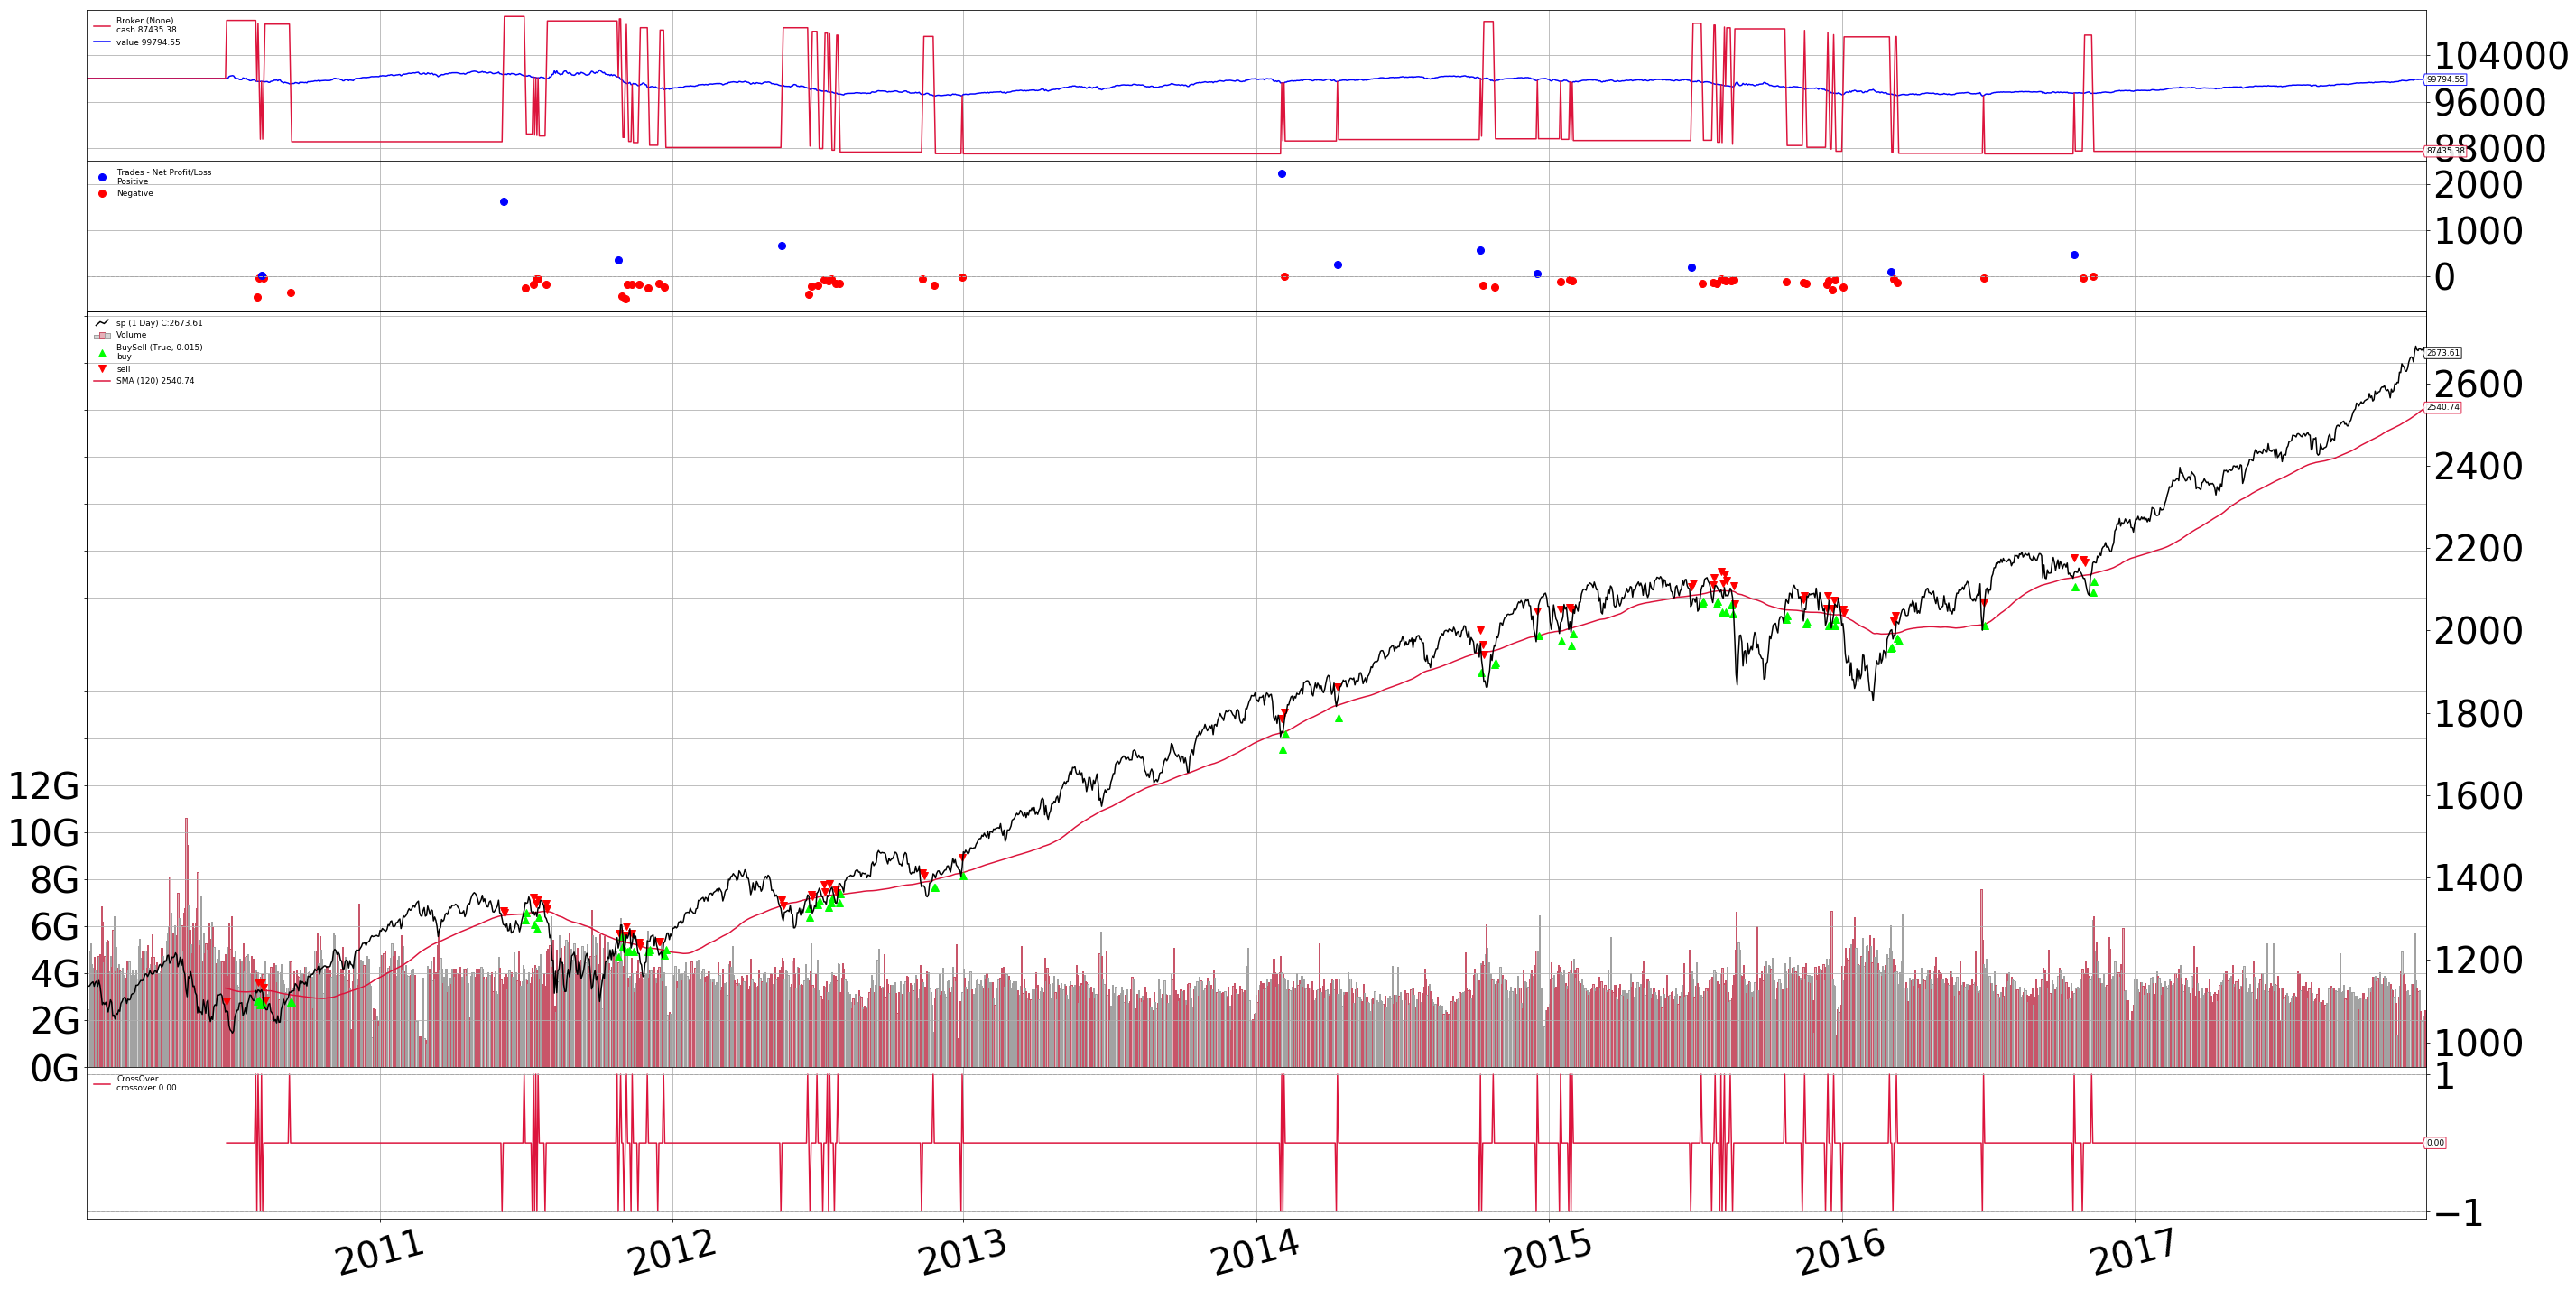

Final Portfolio Value: 99794.55


In [4]:
class MomentumStrategy_demo(bt.Strategy):
    params = (('start_date','2000-01-01'),
              ('end_date','2018-01-01'),
             ('duration', 30),
             ('sma', 120),)
     
  
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datadate = self.datas[0].datetime.date(0)
        self.order = None
        self.sma =  bt.indicators.SMA(self.dataclose, period = self.params.sma)
        self.crossover = bt.indicators.CrossOver(self.dataclose, self.sma)
    

    def start(self):
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):

        
            # Always long or short $10000 securities
        size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

            # Check if we are in the market
        if not self.position :
                #Open position

                # BUY if:
                # short line cross long line from below 
            if  self.dataclose[0] > self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
            if  self.dataclose[0] < self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)


            #Exit position
        elif self.position.size > 0 and  self.dataclose[0] < self.sma[0] :
                #Exit the long position
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
            self.close()
  
        elif self.position.size < 0 and  self.dataclose[0] > self.sma[0] :
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]Buy CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
            self.close()
                
cerebro = bt.Cerebro()               
cerebro.addstrategy(MomentumStrategy_demo)

datapath = os.path.join('sp.csv')
    
    
    
    # Create a Data Feed
    
data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=pd.to_datetime('2010-01-01'),
        # Do not pass values before this date
        todate=pd.to_datetime('2018-01-01'),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
cerebro.adddata(data)

    # Set our desired cash start
cerebro.broker.setcash(100000.0)

    # Write output
cerebro.addwriter(bt.WriterFile, out='out.csv',csv=True)

    # Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
start_value = cerebro.broker.getvalue()
    # Run over everything
cerebro.broker.setcommission(commission=0.00)    
cerebro.run()
    
    
cerebro.plot()

    # Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
  
    


Starting Portfolio Value: 100000.00
2010-01-04, Close, 1132.99 ; Position 0.000000
2010-01-05, Close, 1136.52 ; Position 0.000000
2010-01-06, Close, 1137.14 ; Position 0.000000
2010-01-07, Close, 1141.69 ; Position 0.000000
2010-01-08, Close, 1144.98 ; Position 0.000000
2010-01-11, Close, 1146.98 ; Position 0.000000
2010-01-12, Close, 1136.22 ; Position 0.000000
2010-01-13, Close, 1145.68 ; Position 0.000000
2010-01-14, Close, 1148.46 ; Position 0.000000
2010-01-15, Close, 1136.03 ; Position 0.000000
2010-01-19, Close, 1150.23 ; Position 0.000000
2010-01-20, Close, 1138.04 ; Position 0.000000
2010-01-21, Close, 1116.48 ; Position 0.000000
2010-01-22, Close, 1091.76 ; Position 0.000000
2010-01-25, Close, 1096.78 ; Position 0.000000
2010-01-26, Close, 1092.17 ; Position 0.000000
2010-01-27, Close, 1097.50 ; Position 0.000000
2010-01-28, Close, 1084.53 ; Position 0.000000
2010-01-29, Close, 1073.87 ; Position 0.000000
2010-02-01, Close, 1089.19 ; Position 0.000000
2010-02-02, Close, 1103.

2011-01-28, Close, 1276.34 ; Position -8.186455
2011-01-31, Close, 1286.12 ; Position -8.186455
2011-02-01, Close, 1307.59 ; Position -8.186455
2011-02-02, Close, 1304.03 ; Position -8.186455
2011-02-03, Close, 1307.10 ; Position -8.186455
2011-02-04, Close, 1310.87 ; Position -8.186455
2011-02-07, Close, 1319.05 ; Position -8.186455
2011-02-08, Close, 1324.57 ; Position -8.186455
2011-02-09, Close, 1320.88 ; Position -8.186455
2011-02-10, Close, 1321.87 ; Position -8.186455
2011-02-11, Close, 1329.15 ; Position -8.186455
2011-02-14, Close, 1332.32 ; Position -8.186455
2011-02-15, Close, 1328.01 ; Position -8.186455
2011-02-16, Close, 1336.32 ; Position -8.186455
2011-02-17, Close, 1340.43 ; Position -8.186455
2011-02-18, Close, 1343.01 ; Position -8.186455
2011-02-22, Close, 1315.44 ; Position -8.186455
2011-02-23, Close, 1307.40 ; Position -8.186455
2011-02-24, Close, 1306.10 ; Position -8.186455
2011-02-24, [Exit]Buy CREATE, 1306.10
2011-02-25, BUY EXECUTED, 1307.34
2011-02-25, Clos

2014-09-30, Close, 1972.29 ; Position 5.043246
2014-10-01, Close, 1946.16 ; Position 5.043246
2014-10-02, Close, 1946.17 ; Position 5.043246
2014-10-03, Close, 1967.90 ; Position 5.043246
2014-10-06, Close, 1964.82 ; Position 5.043246
2014-10-07, Close, 1935.10 ; Position 5.043246
2014-10-08, Close, 1968.89 ; Position 5.043246
2014-10-09, Close, 1928.21 ; Position 5.043246
2014-10-10, Close, 1906.13 ; Position 5.043246
2014-10-13, Close, 1874.74 ; Position 5.043246
2014-10-14, Close, 1877.70 ; Position 5.043246
2014-10-15, Close, 1862.49 ; Position 5.043246
2014-10-16, Close, 1862.76 ; Position 5.043246
2014-10-17, Close, 1886.76 ; Position 5.043246
2014-10-20, Close, 1904.01 ; Position 5.043246
2014-10-21, Close, 1941.28 ; Position 5.043246
2014-10-22, Close, 1927.11 ; Position 5.043246
2014-10-23, Close, 1950.82 ; Position 5.043246
2014-10-23, [Exit]SELL CREATE, 1950.82
2014-10-24, SELL EXECUTED, 1951.59
2014-10-24, Close, 1964.58 ; Position 0.000000
2014-10-24, SELL CREATE, 1964.58


/Applications/anaconda/envs/py36/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda/envs/py36/lib/pytho

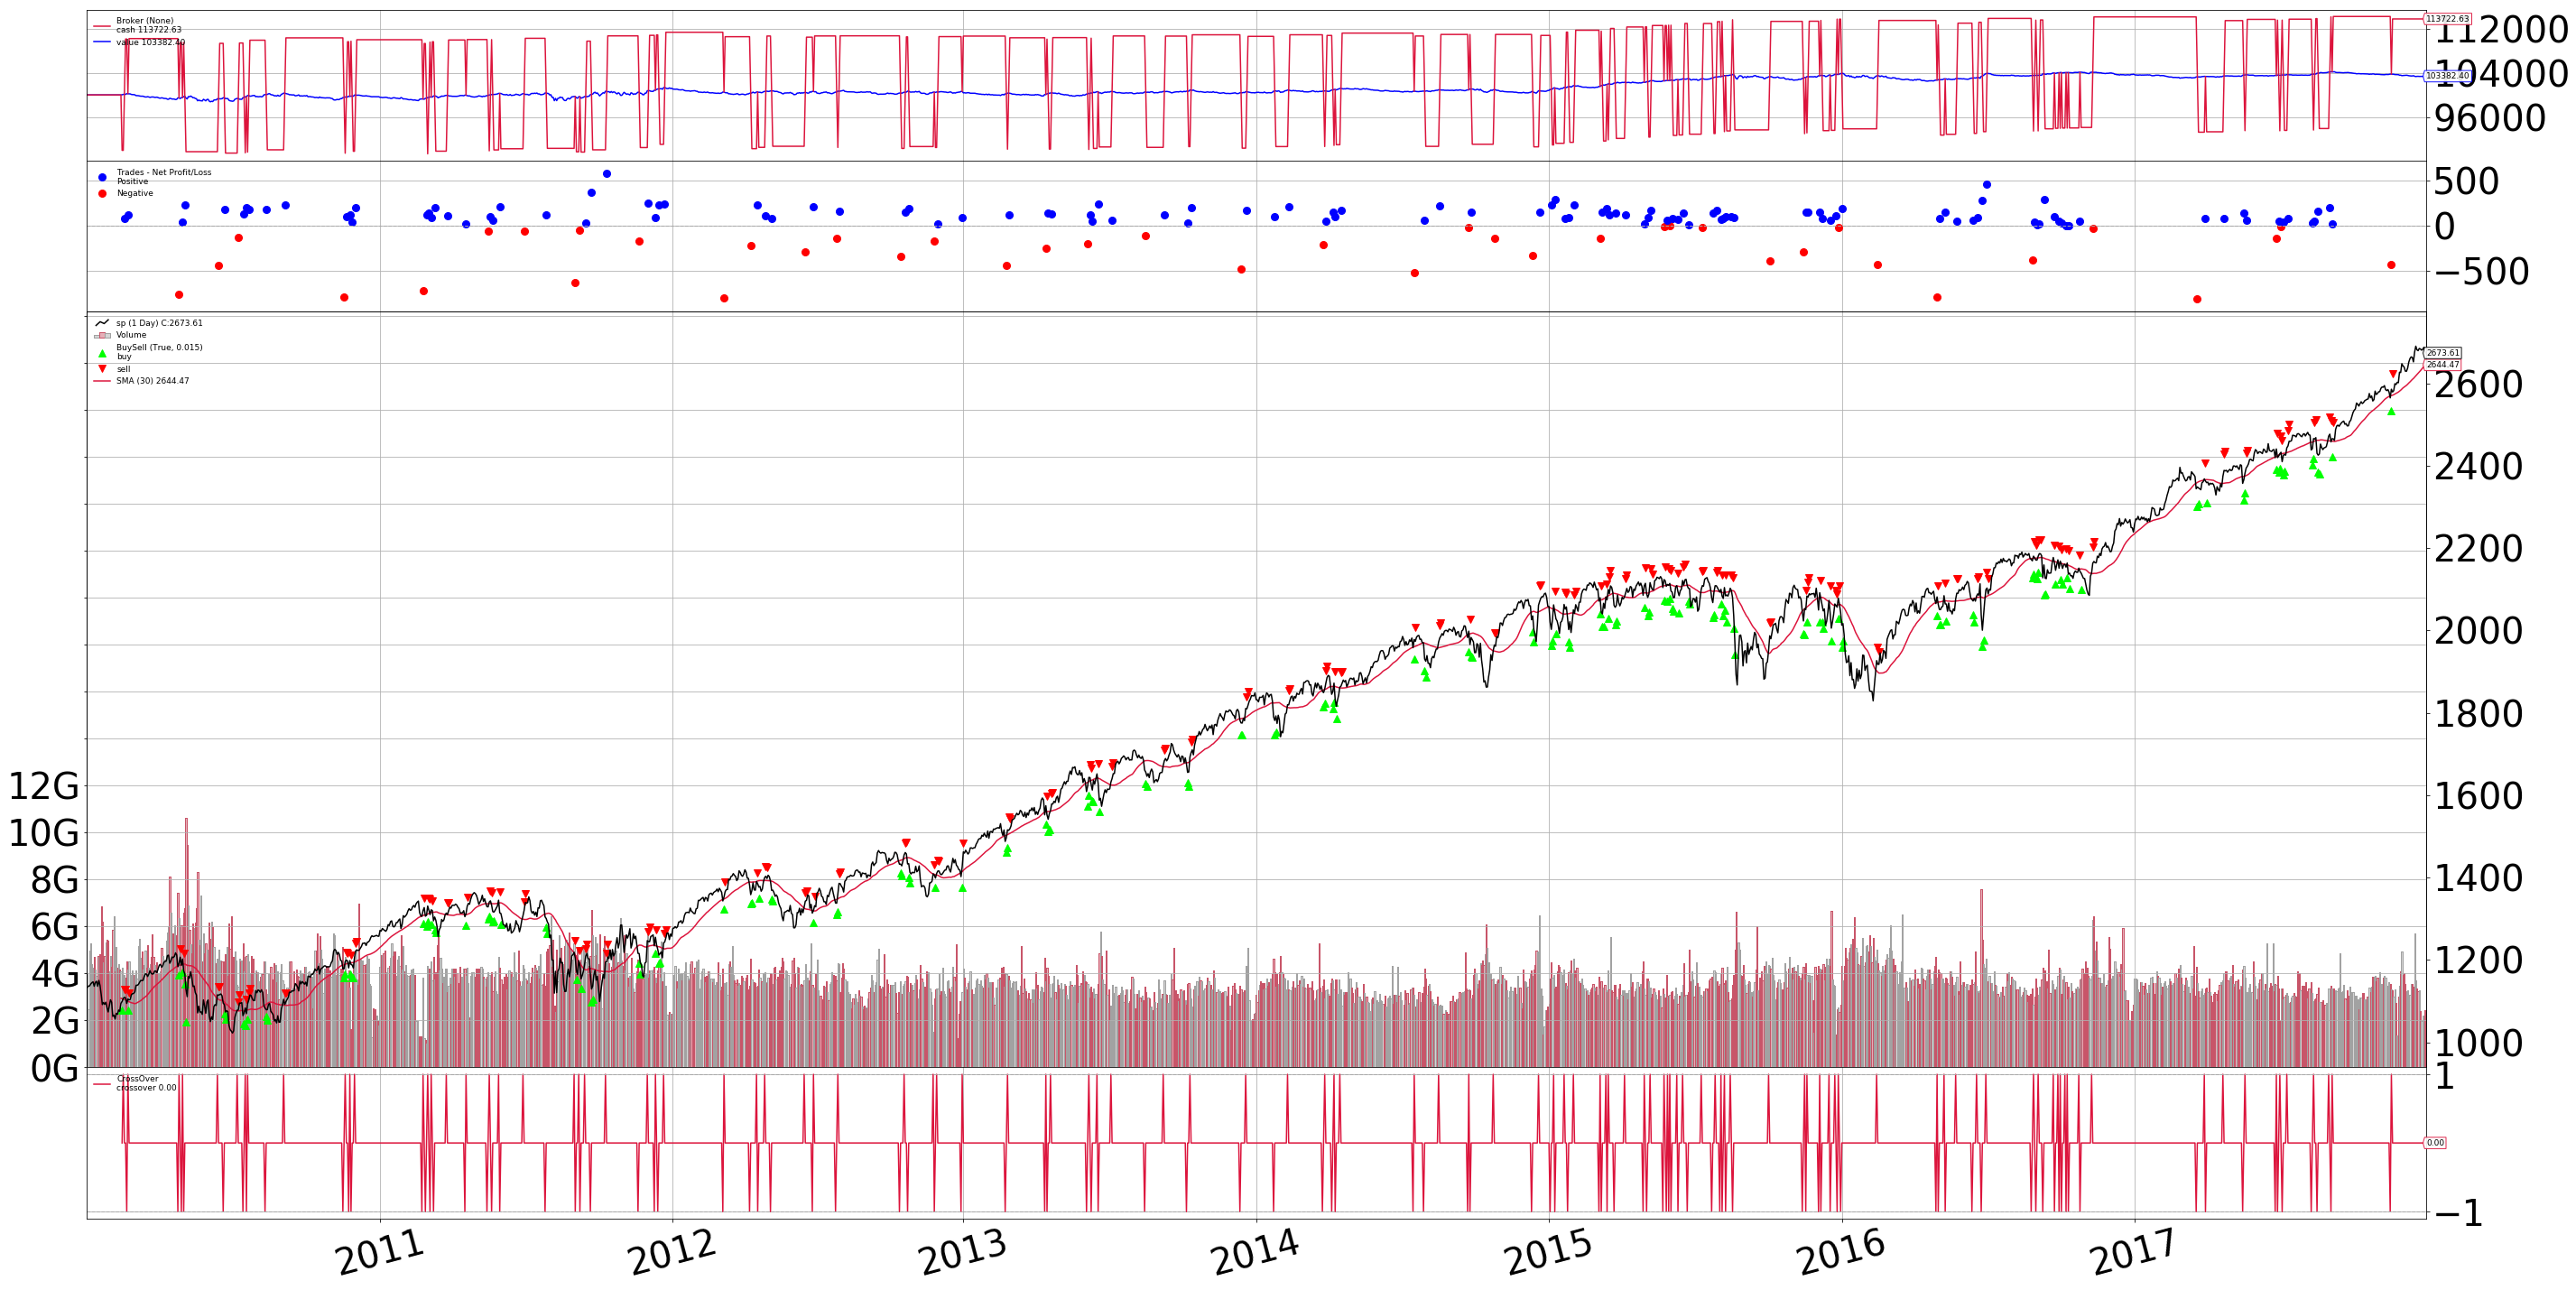

Final Portfolio Value: 103382.40


In [5]:
# Create a Stratey
class MeanReversionStrategy_demo(bt.Strategy):
    params = (('start_date','2000-01-01'),
              ('end_date','2018-01-01'),
             ('duration', 30),
             ('sma', 30),)
     
  
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datadate = self.datas[0].datetime.date(0)
        self.order = None
        self.sma =  bt.indicators.SMA(self.dataclose, period = self.params.sma)
        self.crossover = bt.indicators.CrossOver(self.dataclose, self.sma)
    

    def start(self):
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):

        
            # Always long or short $10000 securities
        size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

            # Check if we are in the market
        if not self.position :
                #Open position

                # BUY if:
                # short line cross long line from below 
            if  self.dataclose[0] < self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
            if  self.dataclose[0] > self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)


            #Exit position
        elif self.position.size > 0 and  self.dataclose[0] > self.sma[0] :
                #Exit the long position
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
            self.close()
  
        elif self.position.size < 0 and  self.dataclose[0] < self.sma[0] :
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]Buy CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
            self.close()
  
                
                
cerebro = bt.Cerebro()               
cerebro.addstrategy(MeanReversionStrategy_demo)

datapath = os.path.join('sp.csv')
    
    
    
    # Create a Data Feed
    
data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=pd.to_datetime('2010-01-01'),
        # Do not pass values before this date
        todate=pd.to_datetime('2018-01-01'),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
cerebro.adddata(data)

    # Set our desired cash start
cerebro.broker.setcash(100000.0)

    # Write output
    #cerebro.addwriter(bt.WriterFile, out='%s.csv'%label,csv=True)

    # Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
start_value = cerebro.broker.getvalue()
    # Run over everything
cerebro.broker.setcommission(commission=0.00)
cerebro.run()
    
    
cerebro.plot()

    # Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
  
    

      

In [6]:
class MomentumStrategy(bt.Strategy):
    params = (('start_date','2010-01-01'),
              ('end_date','2018-01-01'),
             ('duration', 30),
             ('sma', 120),
             )
    
  
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        #dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].high
        self.datadate = self.datas[0].datetime.date(0)
        self.order = None
        self.sma =  bt.indicators.SMA(self.datas[0], period = self.params.sma)
        #self.crossover = bt.indicators.CrossOver(self.sma, self.dataclose)
        
    
    def start(self):
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):

        cur_date = pd.to_datetime(self.datetime.date(ago=0))
        if pd.to_datetime(self.params.start_date) <=  cur_date and pd.to_datetime(self.params.end_date) > cur_date:
            
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            # Check if an order is pending ... if yes, we cannot send a 2nd one
            if self.order:
                return

            # Check if we are in the market
            if not self.position :
                #Open position

                # BUY if:
                # short line cross long line from below 
                if  self.dataclose[0] >= self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(size=size)
                if  self.dataclose[0] < self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(size=size)


            #Exit position
            elif self.position.size > 0 and self.dataclose[0] < self.sma[0]:
                #Exit the long position
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
  
            elif self.position.size < 0 and self.dataclose[0] >= self.sma[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]Buy CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
                self.close()
        if  pd.to_datetime(self.params.end_date) == cur_date:
            if self.position:
                self.close()


In [7]:
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (('start_date','2000-01-01'),
              ('end_date','2018-01-01'),
             ('duration', 30),
             ('sma', 30),)
     
  
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        #dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datadate = self.datas[0].datetime.date(0)
        self.order = None
        self.sma =  bt.indicators.SMA(self.dataclose, period = self.params.sma)
        self.crossover = bt.indicators.CrossOver(self.dataclose, self.sma)
    

    def start(self):
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):

        
            # Always long or short $10000 securities
        size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

            # Check if we are in the market
        if not self.position :
                #Open position

                # BUY if:
                # short line cross long line from below 
            if  self.dataclose[0] < self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)
            if  self.dataclose[0] > self.sma[0] :
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    #print (self.histo.get(ago=-1, size=3))
                    #print (self.histo.get(ago=0, size=3))
                    # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)


            #Exit position
        elif self.position.size > 0 and  self.dataclose[0] > self.sma[0] :
                #Exit the long position
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
            self.close()
  
        elif self.position.size < 0 and  self.dataclose[0] < self.sma[0] :
                # SELL, SELL, SELL!!! (with all possible default parameters)
            self.log('[Exit]Buy CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
            self.close()
  

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda/envs/py36/lib/pytho

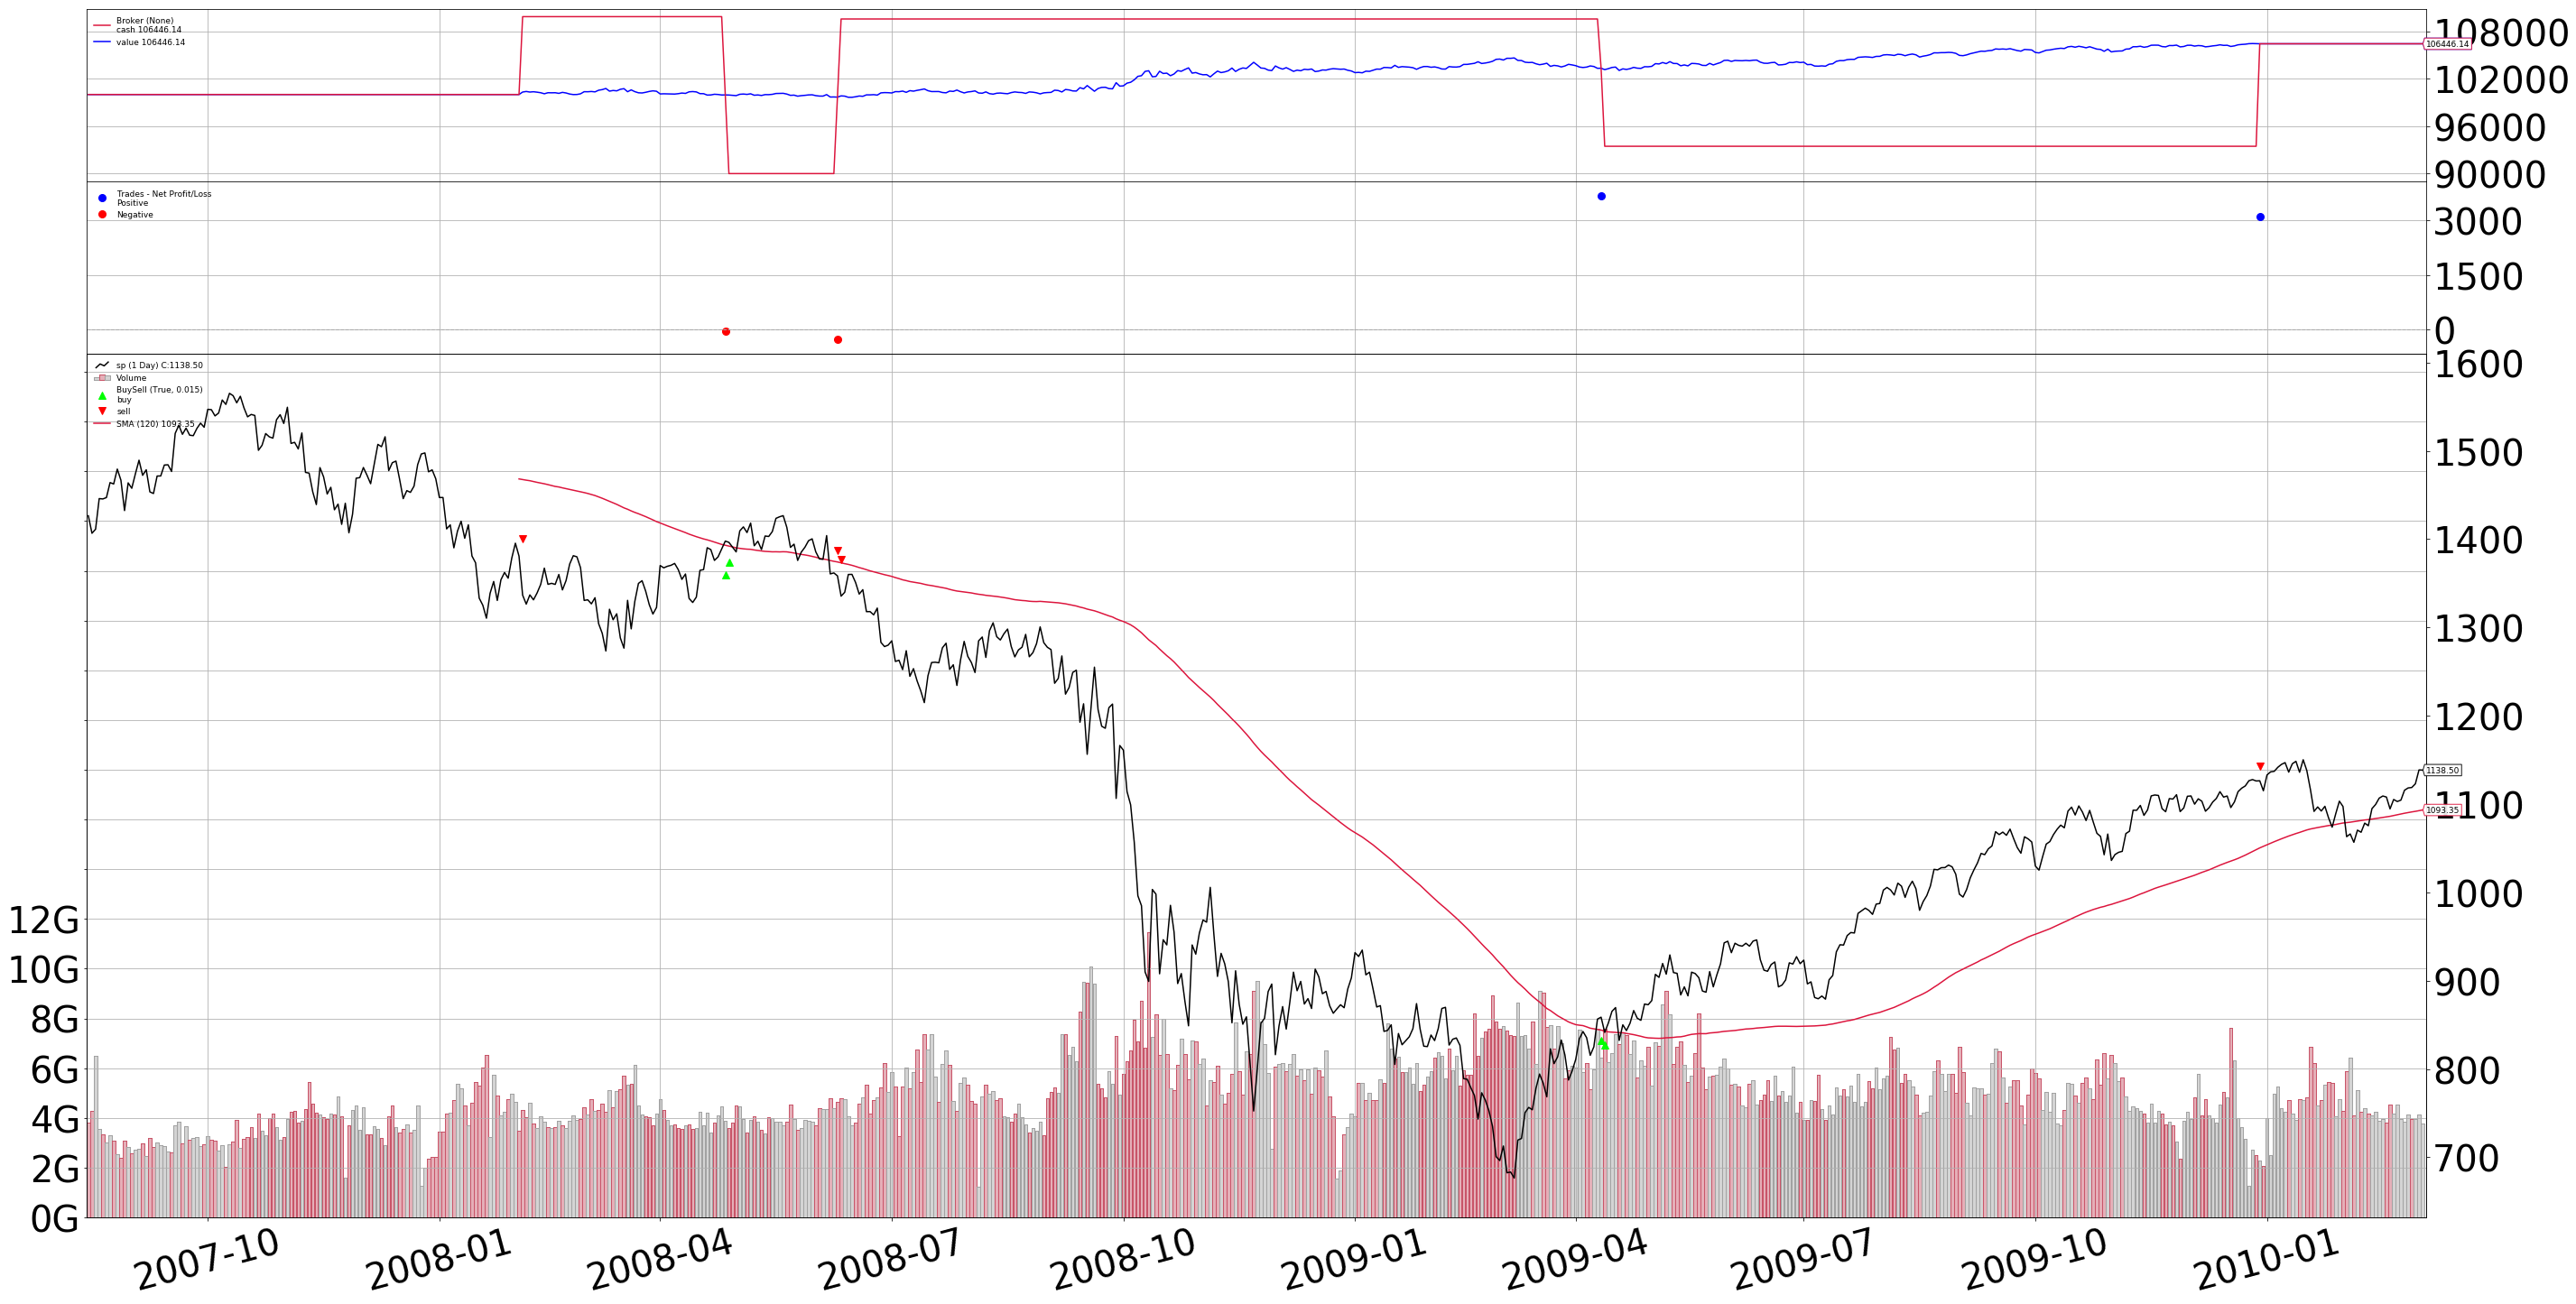

6446.137682957444

In [77]:
run_backtest(MomentumStrategy, startdate = '2008-01-01', duration = 520, label='m0', plot=True) 

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda/envs/py36/lib/pytho

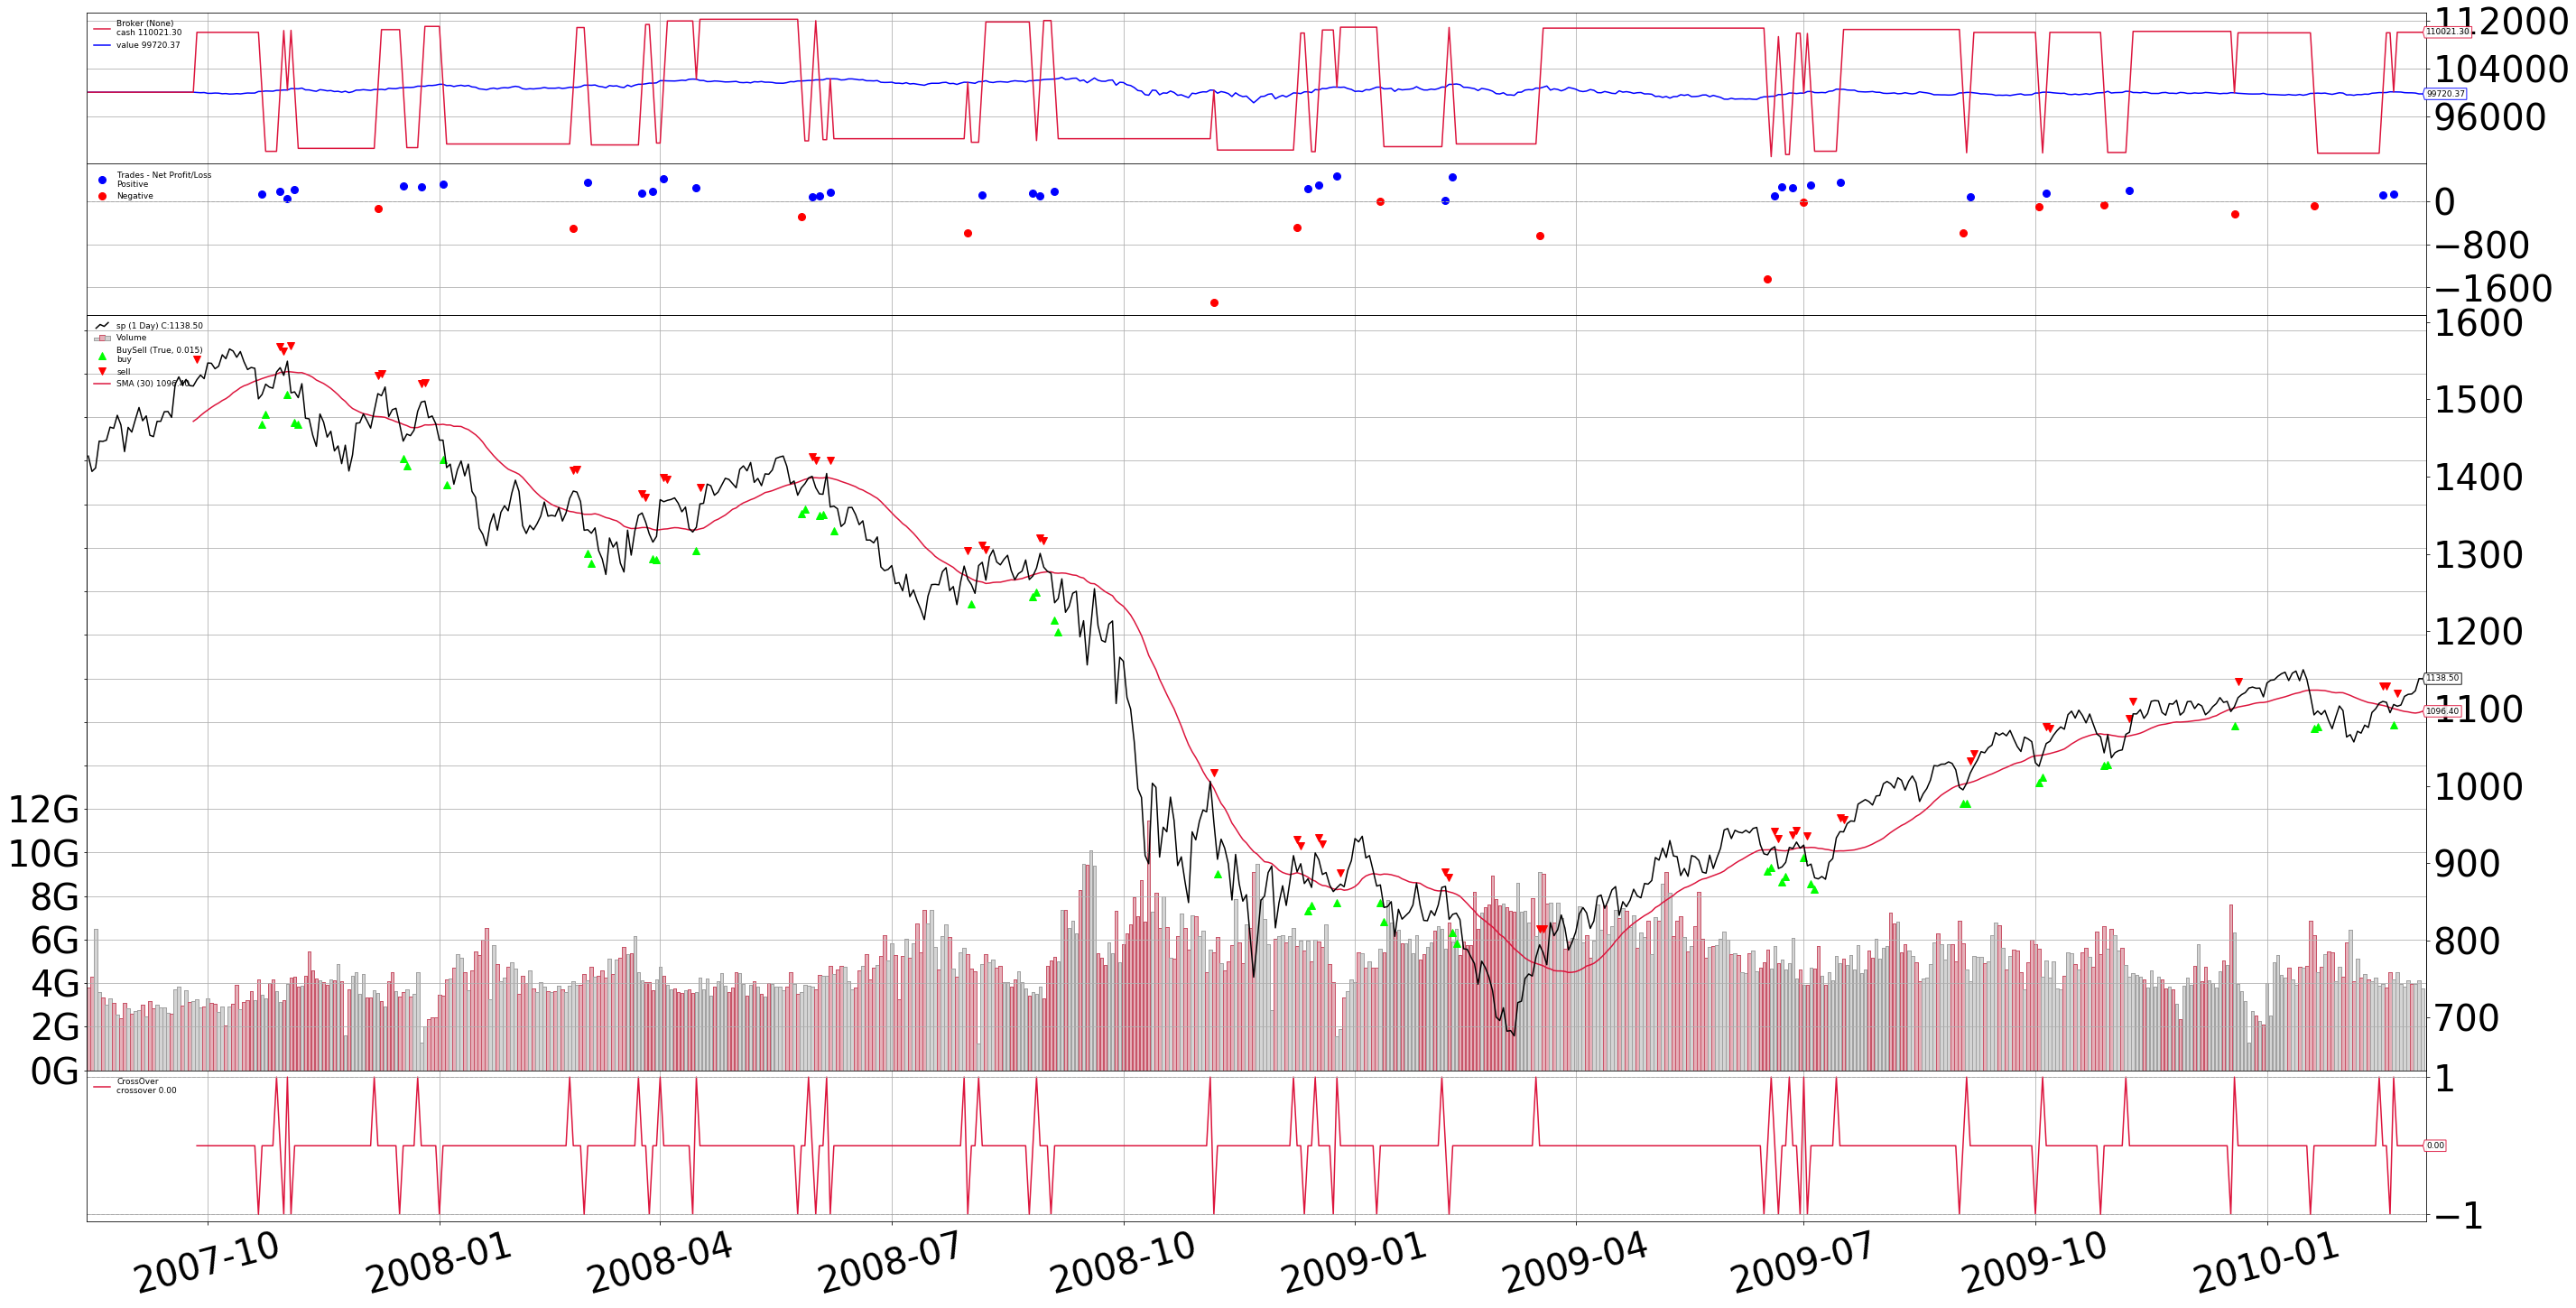

-279.62832096067723

In [78]:
run_backtest(MeanReversionStrategy, startdate = '2008-01-01', duration = 520, label='mr', plot=True) 

Starting Portfolio Value: 100000.00
Loaded model from disk
Loaded scaler from disk
mean reversion day
current ratio: 1.0
2016-12-29, SELL 2.22 at price 2249.26
2016-12-30, SELL EXECUTED, 2251.61
mean reversion day
current ratio: 1.0
2016-12-30, SELL 2.23 at price 2238.83
2017-01-03, SELL EXECUTED, 2251.57
mean reversion day
current ratio: 1.0
2017-01-03, SELL 2.21 at price 2257.83
2017-01-04, SELL EXECUTED, 2261.60
mean reversion day
current ratio: 1.0
2017-01-04, SELL 2.20 at price 2270.75
2017-01-05, SELL EXECUTED, 2268.18
mean reversion day
current ratio: 1.0
2017-01-05, SELL 2.20 at price 2269.00
2017-01-06, SELL EXECUTED, 2271.14
mean reversion day
current ratio: 1.0
2017-01-06, SELL 2.20 at price 2276.98
2017-01-09, SELL EXECUTED, 2273.59
mean reversion day
current ratio: 1.0
2017-01-09, SELL 2.20 at price 2268.90
2017-01-10, SELL EXECUTED, 2269.72
mean reversion day
current ratio: 1.0
2017-01-10, SELL 2.20 at price 2268.90
2017-01-11, SELL EXECUTED, 2268.60
mean reversion day
cu

current ratio: 1.0
2017-04-20, SELL 0.01 at price 2355.84
2017-04-21, SELL EXECUTED, 2354.74
mean reversion day
current ratio: 1.0
2017-04-21, SELL 0.00 at price 2348.69
2017-04-24, SELL EXECUTED, 2370.33
mean reversion day
current ratio: 1.0
2017-04-24, SELL 4.24 at price 2374.15
2017-04-25, SELL EXECUTED, 2381.51
mean reversion day
current ratio: 1.0
2017-04-25, SELL 4.23 at price 2388.61
2017-04-26, SELL EXECUTED, 2388.98
mean reversion day
current ratio: 1.0
2017-04-26, SELL 4.21 at price 2387.45
2017-04-27, SELL EXECUTED, 2389.70
mean reversion day
current ratio: 1.0
2017-04-27, SELL 4.21 at price 2388.77
2017-04-28, SELL EXECUTED, 2393.68
mean reversion day
current ratio: 1.0
2017-04-28, BUY 0.01 at price 2384.20
2017-05-01, BUY EXECUTED, 2388.50
mean reversion day
current ratio: 1.0
2017-05-01, SELL 4.21 at price 2388.33
2017-05-02, SELL EXECUTED, 2391.05
mean reversion day
current ratio: 1.0
2017-05-02, SELL 4.21 at price 2391.17
2017-05-03, SELL EXECUTED, 2386.50
mean reversio

mean reversion day
current ratio: 1.0
2017-08-07, SELL 4.08 at price 2480.91
2017-08-08, SELL EXECUTED, 2478.35
mean reversion day
current ratio: 1.0
2017-08-08, SELL 4.08 at price 2474.92
2017-08-09, SELL EXECUTED, 2465.35
mean reversion day
current ratio: 1.0
2017-08-09, BUY 0.03 at price 2474.02
2017-08-10, BUY EXECUTED, 2465.38
mean reversion day
current ratio: 1.0
2017-08-10, BUY 4.09 at price 2438.21
2017-08-11, BUY EXECUTED, 2441.04
mean reversion day
current ratio: 1.0
2017-08-11, BUY 4.08 at price 2441.32
2017-08-14, BUY EXECUTED, 2454.96
mean reversion day
current ratio: 1.0
2017-08-14, BUY 0.01 at price 2465.84
2017-08-15, BUY EXECUTED, 2468.66
mean reversion day
current ratio: 1.0
2017-08-15, BUY 0.00 at price 2464.61
2017-08-16, BUY EXECUTED, 2468.63
mean reversion day
current ratio: 1.0
2017-08-16, SELL 0.00 at price 2468.11
2017-08-17, SELL EXECUTED, 2462.95
mean reversion day
current ratio: 1.0
2017-08-17, BUY 4.08 at price 2430.01
2017-08-18, BUY EXECUTED, 2427.64
mean

mean reversion day
current ratio: 1.0
2017-11-24, BUY 0.03 at price 2602.42
2017-11-27, BUY EXECUTED, 2602.66
mean reversion day
current ratio: 1.0
2017-11-27, BUY 0.02 at price 2601.42
2017-11-28, BUY EXECUTED, 2605.94
mean reversion day
current ratio: 1.0
2017-11-28, BUY 0.04 at price 2627.04
2017-11-29, BUY EXECUTED, 2627.82
mean reversion day
current ratio: 1.0
2017-11-29, BUY 0.04 at price 2626.07
2017-11-30, BUY EXECUTED, 2633.93
mean reversion day
current ratio: 1.0
2017-11-30, BUY 0.05 at price 2647.58
2017-12-01, BUY EXECUTED, 2645.10
mean reversion day
current ratio: 1.0
2017-12-01, BUY 0.05 at price 2642.22
2017-12-04, BUY EXECUTED, 2657.19
mean reversion day
current ratio: 1.0
2017-12-04, BUY 0.04 at price 2639.44
2017-12-05, BUY EXECUTED, 2639.78
mean reversion day
current ratio: 1.0
2017-12-05, BUY 0.03 at price 2629.57
2017-12-06, BUY EXECUTED, 2626.24
mean reversion day
current ratio: 1.0
2017-12-06, BUY 0.03 at price 2629.27
2017-12-07, BUY EXECUTED, 2628.38
mean rever

mean reversion day
current ratio: 1.0
2018-03-16, SELL 3.65 at price 2752.01
2018-03-19, SELL EXECUTED, 2741.38
mean reversion day
current ratio: 1.0
2018-03-19, BUY 0.01 at price 2712.92
2018-03-20, BUY EXECUTED, 2715.05
mean reversion day
current ratio: 1.0
2018-03-20, SELL 3.68 at price 2716.94
2018-03-21, SELL EXECUTED, 2714.99
mean reversion day
current ratio: 1.0
2018-03-21, SELL 0.01 at price 2711.93
2018-03-22, SELL EXECUTED, 2691.36
mean reversion day
current ratio: 1.0
2018-03-22, BUY 0.04 at price 2643.69
2018-03-23, BUY EXECUTED, 2646.71
mean reversion day
current ratio: 1.0
2018-03-23, BUY 0.11 at price 2588.26
2018-03-26, BUY EXECUTED, 2619.35
mean reversion day
current ratio: 1.0
2018-03-26, BUY 3.68 at price 2658.55
2018-03-27, BUY EXECUTED, 2667.57
mean reversion day
current ratio: 1.0
2018-03-27, BUY 0.09 at price 2612.62
2018-03-28, BUY EXECUTED, 2611.30
mean reversion day
current ratio: 1.0
2018-03-28, BUY 0.08 at price 2605.00
2018-03-29, BUY EXECUTED, 2614.41
mean

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda/envs/py36/lib/pytho

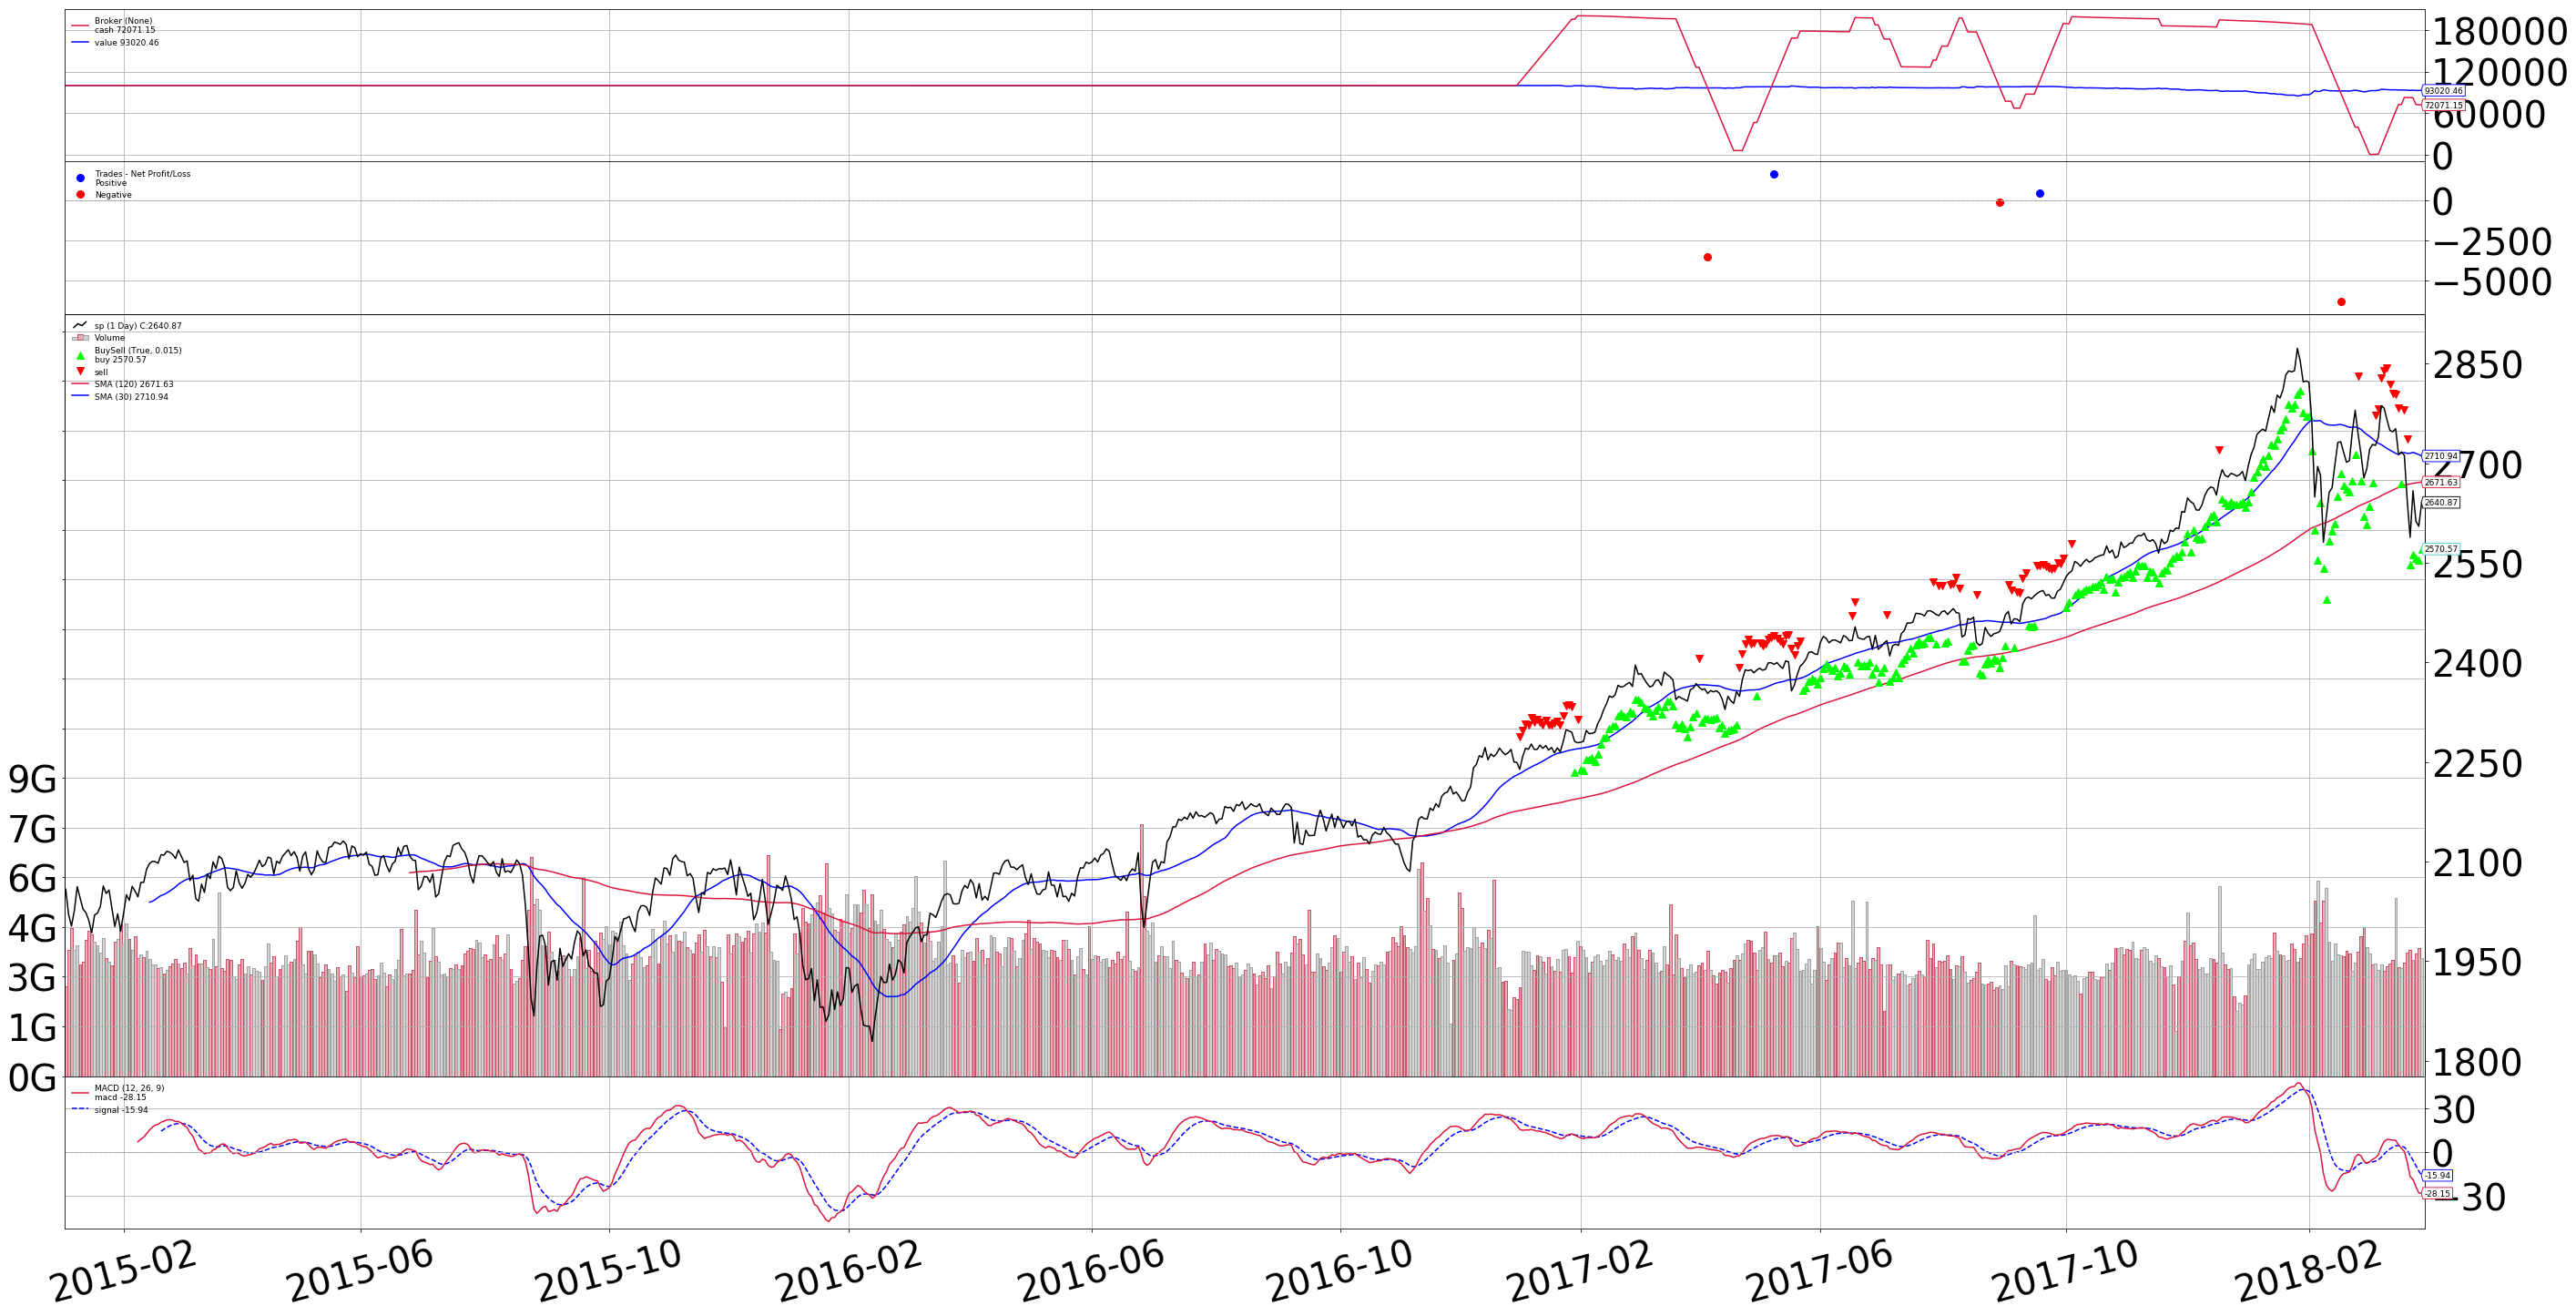

Final Portfolio Value: 93020.46


In [75]:
class one_trade:
        def __init__(self, duration, amount, type_of_trade):
            self.duration = duration
            self.amount = amount
            self.type_of_trade = type_of_trade
            self.pos = 0
            
        def get_amount(self):
            return self.amount
        def get_duration(self):
            return self.duration
        def duration_elapse(self):
            #print ('time passed')
            self.duration -= 1
        def get_type(self):
            return self.type_of_trade
        def get_pos(self):
            return self.pos
        def change_pos(self, pos):
            self.pos = pos



class combined_train_test(bt.Strategy):
    params = (
        ('start_date','2010-01-01'),
        ('end_date','2010-01-01'),
        ('collecting_data_date','2018-01-01'),
        ('duration', 30),
        ('macd1', 12),
        ('macd2', 26),
        ('macd3', 9),
        ('ema1',8),
        ('ema2',28),
        ('rsi_14', 14),
        ('over_bought',70.0),
        ('over_sold',30.0),
        ('sma_mo', 120),
        ('sma_mr', 30),
        ('continue_train', True)
        
    )
    
    
    def compute_hurst_exponent(arr):
        num_lag = 18
        lag_arr = np.arange(2,2+num_lag)
        tau_arr = np.zeros(num_lag)
                #  Step through the different lags
        for i in range(num_lag):
            lag = lag_arr[i]
                    #  produce price difference with lag
            arr_diff = np.diff(arr,lag)
                    #  Calculate the variance of the differnce vector
            tau_arr[i] = np.sqrt(np.std(arr_diff))
                #  linear fit to double-log graph (gives power)
        m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
                # calculate hurst
        hurst = m[0]*2
        return hurst
            
    def compute_sharpe(arr):
        ret = np.divide(np.diff(arr),arr[:-1])
        return(np.mean(ret)/np.std(ret))
    
        
            
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.datavolume = self.datas[0].volume
        
        
        
        self.sma_mo =  bt.indicators.SMA(self.datas[0], period = self.params.sma_mo)
        self.sma_mr =  bt.indicators.SMA(self.datas[0], period = self.params.sma_mr)
        
        
        #self.crossover = bt.indicators.CrossOver(self.sma, self.dataclose)
        #self.sell_signal = bt.indicators.CrossOver(bt.ind.RSI(), self.params.over_bought)
        #self.buy_signal = bt.indicators.CrossOver(bt.ind.RSI(), self.params.over_sold)
        
    
        
        # Add a LSTM
        self.model = Sequential()
        
        self.model.add(LSTM(1000, return_sequences=True, activation='sigmoid',
               input_shape=(6, 10)))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(500, return_sequences=True, activation='sigmoid'))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(250))  # return a single vector of dimension 32
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
        self.estimator = GradientBoostingClassifier(n_estimators=500, max_depth=4, verbose=1)
        self.scaler = None
        
        

        
        # Add Momentum indicators
        #self.ema_short =  bt.indicators.EMA(self.datas[0], period = self.params.ema1)
        #self.ema_long =  bt.indicators.EMA(self.datas[0], period = self.params.ema2)
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macd3)
        
        self.histo = self.macd.macd - self.macd.signal
        #self.diff = self.ema_short - self.ema_long
        

        
        # containers:
        self.sma_mr_v = []
        self.sma_mo_v = []
        self.date = []
        self.close = []
        self.open = []
        self.high = []
        self.low = []
        self.volume = []
        self.ema1 = []
        self.ema2 = []
        self.macd_line = []
        self.macd_signal = []
        self.macd_hist = []
        self.pnl = []
        
        # define building model_day
        self.model_building_day = pd.to_datetime(self.params.collecting_data_date)+BDay(5)
        self.trade_day = pd.to_datetime(self.params.collecting_data_date)+BDay(20)
        # To keep track of pending orders
        self.total_pnl = 0
        self.mo_value = 0
        self.mr_value = 0
        self.trade_vec = []
        self.regime_vec = []
        self.order = None 
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
     
        cur_date = pd.to_datetime(self.datetime.date(ago=0))
        """
        pnl_mrrr = run_backtest(MeanReversionStrategy, startdate = cur_date, duration = 20, label='mr') 
        pnl_mooo = run_backtest(MomentumStrategy, startdate = cur_date, duration = 20, label='mo')
        if pnl_mrrr > pnl_mooo:
            known_label.append(1)
        if pnl_mrrr <= pnl_mooo:
            known_label.append(0)
        known_dates.append(cur_date) 
        """
            
        if cur_date <= pd.to_datetime(self.params.collecting_data_date):
            
            pnl_mr = run_backtest(MeanReversionStrategy, startdate = cur_date, duration = 20, label='mr') 
            pnl_mo = run_backtest(MomentumStrategy, startdate = cur_date, duration = 20, label='mo')
            if pnl_mr > pnl_mo:
                self.pnl.append(int(1))
            if pnl_mr <= pnl_mo:
                self.pnl.append(int(0))
            self.date.append(cur_date)
            self.close.append(self.dataclose[0])
            self.open.append(self.dataopen[0])
            #self.high.append(self.datahigh[0]) 
            #self.low.append(self.datalow[0]) 
            self.volume.append(self.datavolume[0]) 
            #self.ema1.append(self.ema_short[0]) 
            #self.ema2.append(self.ema_long[0]) 
            self.macd_line.append(self.macd.macd[0])
            self.macd_signal.append(self.macd.signal[0])
            self.macd_hist.append(self.histo[0])
            self.sma_mo_v.append(self.sma_mo[0] )
            self.sma_mr_v.append(self.sma_mr[0] )
        
        if cur_date == pd.to_datetime(self.model_building_day):
            # if model exists, load model and weights
            if os.path.isfile('model.json'):
                json_file = open('model.json', 'r')
                loaded_model_json = json_file.read()
                json_file.close()
                loaded_model = model_from_json(loaded_model_json)
                # load weights into new model
                loaded_model.load_weights("model.h5")
                self.model = loaded_model
                self.model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
                print("Loaded model from disk")
                scalerfile = 'scaler.sav'
                self.scaler = pickle.load(open(scalerfile, 'rb'))
                print('Loaded scaler from disk')

            
            # train the model
            if self.params.continue_train:   
                # build the framework and start training
                df_date = np.array(self.date)
                df_close = np.array(self.close)
                df_open = np.array(self.open)
                #df_high = np.array(self.high)
                #df_low = np.array(self.low)
                df_vol = np.array(self.volume)
                #df_ema_diff = np.array(self.ema1) - np.array(self.ema2)
                df_macd = np.array(self.macd_line)
                df_signal = np.array(self.macd_signal)
                df_hist = np.array(self.macd_hist)
                df_label = np.array(self.pnl)
                df_mo = np.array(self.sma_mo_v)
                df_mr = np.array(self.sma_mr_v)

                df = pd.DataFrame({'date':df_date, 'close':df_close, 'open':df_open, 'vol':df_vol, 'macd':df_macd, 
                                'macd_signal':df_signal, 'macd_hist':df_hist,'mo':df_mo,'mr':df_mr,'label':df_label, }, 

                               columns= ['date','close','open','vol','macd',
                                         'macd_signal','macd_hist','mo','mr','label',],
                                 )

                # define hurst exponent and Sharpe ratio
                print ('number of mr',sum(df_label))
                print ('numbre of mo', len(df_label)-sum(df_label))

                window_indicators = 30
                Indicators = pd.DataFrame(columns=["hurst_exponent",
                                                   "sharpe_ratio",
                                                    'Open_pct',
                                                    'Close_pct',
                                                    'vol',
                                                    'macd',
                                                    'macd_signal',
                                                    'macd_hist',
                                                   'mr',
                                                   'mo',
                                                    'label'])
                Indicators.loc[:,"hurst_exponent"] =df['close'].rolling(window=window_indicators).apply(compute_hurst_exponent)
                Indicators.loc[:,"sharpe_ratio"] = df['close'].rolling(window=window_indicators).apply(compute_sharpe)
                Indicators.loc[:,"Volume_pct"] = df['vol'].pct_change()
                #Indicators.loc[:,"Low_pct"] = df['low'].pct_change()
                #Indicators.loc[:,"High_pct"] = df['high'].pct_change()
                Indicators.loc[:,"Close_pct"] = df['close'].pct_change()
                Indicators.loc[:,"Open_pct"] = df['open'].pct_change()
                #Indicators.loc[:,"ema_diff"] = df['ema_diff']
                Indicators.loc[:,"macd"] = df['macd']
                Indicators.loc[:,"macd_signal"] = df['macd_signal']
                Indicators.loc[:,"macd_hist"] = df['macd_hist']
                Indicators.loc[:,'mo'] = df['mo']
                Indicators.loc[:,'mr'] = df['mr']
                Indicators.loc[:,'label'] = df['label']

                print (len(Indicators))
                # skip first 35
                offset = 45
                length = 6
                # prepare the data
                features = []
                labels = []
                for i in range(offset, len(Indicators)):
                    feature =Indicators[["hurst_exponent",
                                                   "sharpe_ratio",
                                                     "Volume_pct",
                                                    'Open_pct',
                                                    'Close_pct',
                                                    'macd',
                                                    'macd_signal',
                                                    'macd_hist',
                                                    'mo',
                                                    'mr']][i-length:i].values
                    features.append(feature)
                    label = Indicators['label'][i]
                    labels.append(label)   

                features = np.array(features)
                labels= (np.array(labels))
                ratio = 0.9
                off_days = 20
                train_len = int(len(features) * ratio)
                train_x = np.array(features[:train_len])
                train_y = np.array(labels[:train_len])
                test_x = np.array(features[train_len+off_days:])
                test_y = np.array(labels[train_len+off_days:])
                """
                train_len = 2000
                test_len = 100
                train_x = np.array(features[:train_len])
                train_y = np.array(labels[:train_len])
                test_x = np.array(features[train_len+30:train_len+30+test_len])
                test_y = np.array(labels[train_len+30:train_len+30+test_len])
                """

                def scale(train, test):
                    # fit scaler
                    a,b,c = train.shape
                    train = train.reshape(a , b * c)
                    scaler = MinMaxScaler(feature_range=(-1, 1))
                    scaler = scaler.fit(train)
                    # transform train
                    #train = train.reshape(train.shape[0], train.shape[1])
                    train_scaled = scaler.transform(train)
                    train_scaled = train_scaled.reshape(a,b,c)

                    e,f,g = test.shape
                    test = test.reshape(e ,f * g)
                    test_scaled = scaler.transform(test)
                    test_scaled = test_scaled.reshape(e,f,g)

                    return scaler, train_scaled, test_scaled


                self.scaler, train_x, test_x= scale(train_x, test_x)
                
                scalerfile = 'scaler.sav'
                pickle.dump(self.scaler, open(scalerfile, 'wb'))
                
                w_1 = 1
                w_0 = sum(train_y) /(len(train_y) - sum(train_y))
                print (w_0)
                print (w_1)
                self.model.fit(train_x, train_y,  batch_size=32, epochs=100, class_weight={0:w_0, 1:w_1})
                testPredict = np.ravel(self.model.predict_classes(test_x))

                print('resuls for LSTM')
                print('true_label',test_y)
                print('testPredict', testPredict )
                print (metrics.accuracy_score(testPredict, test_y))
                model_json = self.model.to_json()
                with open("model.json", "w") as json_file:
                    json_file.write(model_json)
                # serialize weights to HDF5
                self.model.save_weights("model.h5")
                print("Saved model to disk")
 
            # start trading
        if cur_date >= pd.to_datetime(self.trade_day):
           
            # collect the data first
            close_data = self.dataclose.get(ago=0, size=40)
            open_data = self.dataopen.get(ago=0, size=40)
            #high_data = self.datahigh.get(ago=0, size=40)
            #low_data = self.datalow.get(ago=0, size=40)
            vol_data = self.datavolume.get(ago=0, size=40)
            #ema1_data = self.ema_short.get(ago=0, size=40)
            #ema2_data = self.ema_long.get(ago=0, size=40)
            #ema_diff_data = np.array(ema1_data) - np.array(ema2_data)
            macd_data = self.macd.macd.get(ago=0, size=40)
            signal_data = self.macd.signal.get(ago=0, size=40)
            hist_data = self.histo.get(ago=0, size=40)
            mo_data = self.sma_mo.get(ago=0, size=40) 
            mr_data = self.sma_mr.get(ago=0, size=40) 
            
            df = pd.DataFrame({ 'close':close_data, 'open':open_data, 'vol':vol_data, 'macd':macd_data, 
                            'macd_signal':signal_data, 'macd_hist':hist_data,'mo':mo_data, 'mr':mr_data}, 
                              
                           columns= ['close','open','vol', 'macd',
                                     'macd_signal','macd_hist','mo','mr'],
                             )
            
            
            window_indicators = 30
            Indicators = pd.DataFrame(columns=["hurst_exponent",
                                               "sharpe_ratio",
                                               "Volume_pct",
                                               "Open_pct",
                                               "Close_pct",
                                                'macd',
                                                'macd_signal',
                                                'macd_hist',
                                               'mo',
                                               'mr',
                                                ])
            Indicators.loc[:,"hurst_exponent"] =df['close'].rolling(window=window_indicators).apply(compute_hurst_exponent)
            Indicators.loc[:,"sharpe_ratio"] = df['close'].rolling(window=window_indicators).apply(compute_sharpe)
            Indicators.loc[:,"Volume_pct"] = df['vol'].pct_change()
            #Indicators.loc[:,"Low_pct"] = df['low'].pct_change()
            #Indicators.loc[:,"High_pct"] = df['high'].pct_change()
            Indicators.loc[:,"Close_pct"] = df['close'].pct_change()
            Indicators.loc[:,"Open_pct"] = df['open'].pct_change()
            #Indicators.loc[:,"ema_diff"] = df['ema_diff']
            Indicators.loc[:,"macd"] = df['macd']
            Indicators.loc[:,"macd_signal"] = df['macd_signal']
            Indicators.loc[:,"macd_hist"] = df['macd_hist']
            Indicators.loc[:,"mo"] = df['mo']
            Indicators.loc[:,"mr"] = df['mr']
            features = Indicators.iloc[-6:].values
            b,c = features.shape
            #display(Indicators)
            features = features.reshape(1 , b * c)
            features = self.scaler.transform(features)
            features = features.reshape(1 , b , c)
            regime = int(self.model.predict_classes(features))
            self.regime_vec.append(int(regime))
            if regime == 0:
                print ('momentum day')
            else:
                print ('mean reversion day')
              
                
            print ('current ratio:', sum(self.regime_vec)/(len(self.regime_vec)))
            
            # add code to output the regime vec
            ########################################
           # market_regime_vec.append(regime)
           # market_date_vec.append(cur_date)
            
            
            ########################################
            
            
            # now executing strategy
            # momentum
#######################################################################################  
            # 0 is mo, 1 is mr
            if self.order:
                return
           
            size = 100000./self.dataclose[0]/20
            tt = one_trade(duration = 20, amount = size, type_of_trade = regime)
            self.trade_vec.append(tt)
            #print ('length of trade_vec is:',len(self.trade_vec))
            # total amount to execute
            to_buy = 0
            to_sell = 0
            for trade in self.trade_vec:
                
                # if mo
                if trade.get_type() == 0:
                    # if no position
                    if trade.get_pos() == 0:
                        # if long indicator is activated
                        if self.dataclose[0] > self.sma_mo[0]:
                            #self.log('BUY CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.buy(size=trade.get_amount())
                            to_buy += trade.get_amount()
                            trade.change_pos(1)
                        elif self.dataclose[0] < self.sma_mo[0]:
                            #self.log('SELL CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.sell(size=trade.get_amount())
                            to_sell += trade.get_amount()
                            trade.change_pos(-1)
                    # if in long position        
                    elif trade.get_pos() == 1:      
                        if self.dataclose[0] < self.sma_mo[0]:
                            to_sell += trade.get_amount()
                            #self.order = self.sell(size = trade.get_amount())
                            trade.change_pos(0)
                            #self.log('CLOSED AND SELL CREATE, %.2f' % self.dataclose[0])
                    elif trade.get_pos() == -1:
                        if self.dataclose[0] > self.sma_mo[0]:
                            to_buy += trade.get_amount()
                            #self.order = self.buy(size = trade.get_amount())
                            trade.change_pos(0)
                            #self.log('CLOSED AND BUY CREATE %.2f' % self.dataclose[0])
                # if mr
                elif trade.get_type() == 1:
                    # if no position
                    if trade.get_pos() == 0:
                        # if long indicator us activated
                        if self.dataclose[0] < self.sma_mr[0]:
                            #self.log('BUY CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.buy(size=trade.get_amount())
                            to_buy += trade.get_amount()
                            trade.change_pos(1)
                        elif self.dataclose[0] > self.sma_mr[0]:
                            #self.log('SELL CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.sell(size=trade.get_amount())
                            to_sell += trade.get_amount()
                            trade.change_pos(-1)
                    # if in long position        
                    elif trade.get_pos == 1:        
                        if self.dataclose[0] > self.sma_mo[0]:
                            #self.log('CLOSE AND SELL CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.sell(size=trade.get_amount())
                            to_sell += trade.get_amount()
                            trade.change_pos(0)
                    elif trade.get_pos == -1:
                        if self.dataclose[0] < self.sma_mo[0]:
                            to_buy += trade.get_amount()
                            #self.log('CLOSE AND BUY CREATE, %.2f' % self.dataclose[0])
                            #self.order = self.buy(size=trade.get_amount())
                            trade.change_pos(0)
                            
                # update number of days
                trade.duration_elapse()
                
                # delete if days left == 0
                if trade.get_duration() <= 0:
                    if trade.get_pos() == 1:
                        #self.log('CLOSE AND SELL, %.2f' % self.dataclose[0])
                        #self.order = self.sell(size=trade.get_amount())
                        to_sell += trade.get_amount()
                        trade.change_pos(0)
                    elif trade.get_pos() == -1:
                        #self.log('CLOSE AND BUY, %.2f' % self.dataclose[0])
                        #self.order = self.buy(size=trade.get_amount())
                        to_buy += trade.get_amount()
                        trade.change_pos(0)
                    self.trade_vec.pop(0)
                    

            net = to_buy - to_sell
            if net > 0:
                self.log('BUY {0:.2f} at price {1:.2f}'.format(net, self.dataclose[0]))
                
                self.order = self.buy(size = net)
            elif net < 0:
                self.log('SELL {0:.2f} at price {1:.2f}'.format(-net, self.dataclose[0]))
                self.order = self.sell(size = -net)
           

        
        
cerebro = bt.Cerebro()
  
cerebro.addstrategy(combined_train_test, collecting_data_date = '2013-01-01', continue_train = False)

datapath = os.path.join('sp.csv')
 
"""   
market_regime_vec = []
market_date_vec = []
known_label = []
known_dates = []
""" 
# Create a Data Feed    
data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=pd.to_datetime('2015-01-01'),
        # Do not pass values before this date
        todate=pd.to_datetime('2014-04-01'),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
cerebro.adddata(data)

    # Set our desired cash start
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0)
    # Write output
    
cerebro.addwriter(bt.WriterFile, out='out.csv',csv=True)

    # Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
cerebro.run()
  
cerebro.plot()

    # Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

